Evaluate the best prediction methods for the Hypothesis A with the small training set
- Variational Inference - Bernoulli and Average Predict methods as well as standard prediction
- Monte Carlo Dropout - Bernoulli and Average predict methods as well as standard prediction
- Baseline Modell / CNN with standard prediction method

In [1]:
# import the needed packages and check version
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("tensorflow: ", tf.__version__) #2.0.0
print("tensorflow_prob: ", tfp.__version__) #

tensorflow:  2.0.0
tensorflow_prob:  0.8.0


In [2]:
#import the helper functions for evaluation
from helper_functions import m_predict_vi as apvi 
from helper_functions import b_predict_vi as bpvi
from helper_functions import b_predict_mc as bpmc
from helper_functions import m_predict_mc as apmc

In [3]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [4]:
#import the fashion mnist dataset (from Zalando)
fashion_mnist = keras.datasets.fashion_mnist
data = fashion_mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = data
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
#preprocess the images
train_x = np.expand_dims(train_images/255.0, axis=3)
test_x = np.expand_dims(test_images/255.0, axis=3)

In [7]:
train_y = train_labels
test_y = test_labels

# get the models

In [8]:
model = tf.keras.models.load_model('A_008_model_b.h5')

W1201 08:54:59.915234  9316 deprecation.py:506] From C:\Users\annar\Anaconda3\envs\ml_env\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (train_x.shape[0] *1.0)

In [10]:
model_vi = keras.Sequential([
    tfp.layers.Convolution2DFlipout(8, kernel_size=(3,3), padding="same", activation='relu', 
                                    kernel_divergence_fn=kernel_divergence_fn, input_shape=(28,28,1)),
    tfp.layers.Convolution2DFlipout(8, kernel_size=(3,3), padding="same", activation='relu', 
                                    kernel_divergence_fn = kernel_divergence_fn),
    keras.layers.MaxPooling2D(2,2),
    tfp.layers.Convolution2DFlipout(16, kernel_size=(3,3), padding="same", activation='relu', 
                                    kernel_divergence_fn=kernel_divergence_fn),
    keras.layers.Flatten(),
    #keras.layers.Dropout((0.5)),
    tfp.layers.DenseFlipout(9, activation='softmax', kernel_divergence_fn=kernel_divergence_fn)
])

W1201 08:55:03.966722  9316 deprecation.py:323] From C:\Users\annar\Anaconda3\envs\ml_env\lib\site-packages\tensorflow_probability\python\layers\util.py:104: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.


In [11]:
#model_vi = tf.keras.models.load_model('B_004_model_vi.h5')
model_vi.load_weights('A_010_model_vi.h5')

In [12]:
model_mc2 = tf.keras.models.load_model('A_008_model_mc.h5')

In [13]:
import tensorflow.keras.backend as K
model_mc2_pred = K.function([model_mc2.input, K.learning_phase()], [model_mc2.output])

# Evaluate the models and prediction functions

We go for one uncertainty measure and order the test dataset accordingly and then check how the accuracy develops

In [14]:
results = pd.read_csv("D_003_results.csv", ";")

In [ ]:
# get the bernoulli predict with the variational inference model
# the testing before showed that the best results were achieved with 25 or 10 pictures per prediction, since those are very
# close I will go with 10 predictions per image since this is computationally less demanding
# 18:38
bern_vi = bpvi.bern_predict_vi(test_x, model_vi, 9, 25)

In [ ]:
df_pred = pd.DataFrame(bern_vi)
results = pd.DataFrame(df_pred[3])
results.columns = ['sort_order']

In [ ]:
results['b_vi'] = df_pred[0]

In [ ]:
results.to_csv("D_003_results.csv", ";")

In [15]:
avg_vi = apvi.average_predict_vi(test_x, model_vi, 9, 25)

C:\Users\annar\MAS Data Science\Masterarbeit\helper_functions\m_predict_vi.py:18: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  max_value = mean.argmax()


In [16]:
p = pd.DataFrame(avg_vi)
results['a_vi'] = p[0]
results['a_vi_std'] = p[3]

In [17]:
results.to_csv("D_003_results.csv", ";")

In [18]:
b_mc = bpmc.b_predict_mc(test_x, model_mc2_pred, 9, 10)

In [19]:
q = pd.DataFrame(b_mc)
results['b_mc'] = q[0]
results['b_mc_std'] = q[3]

In [20]:
results.to_csv("D_003_results.csv", ";")

In [21]:
a_mc = apmc.avg_predict_mc(test_x, model_mc2_pred, 9, 50)

C:\Users\annar\MAS Data Science\Masterarbeit\helper_functions\m_predict_mc.py:17: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  max_value = mean.argmax()


In [22]:
r = pd.DataFrame(a_mc)
results['a_mc'] = r[0]
results['a_mc_std'] = r[3]

In [23]:
results.to_csv("D_003_results.csv", ";")

In [ ]:
results = pd.read_csv("D_003_results.csv", ";")

# do the predictions for the baseline model and the "normal" prediction methods

In [24]:
cnn_pred = []
for i in range(10000):
    j = i + 1
    pred = model.predict(test_x[i:j]).argmax()
    cnn_pred.append(pred)
    #print(pred)

In [25]:
results['cnn'] = cnn_pred

In [26]:
mc_pred = []
for i in range(10000):
    j = i + 1
    pred = model_mc2.predict(test_x[i:j]).argmax()
    mc_pred.append(pred)
    #print(pred)

In [27]:
results['mc'] = mc_pred

In [28]:
vi_pred = []
for i in range(10000):
    j = i + 1
    pred = model_vi.predict(test_x[i:j]).argmax()
    vi_pred.append(pred)
    #print(pred)

In [29]:
results['vi'] = vi_pred

In [30]:
results.to_csv("D_003_results.csv", ";")

# create the tests

In [12]:
results = pd.read_csv("D_003_results.csv", ";")

In [13]:
results['soll'] = test_y

In [14]:
testing = results.sort_values(by=['sort_order'], ascending = True)

In [34]:
testing.head(20)

,Unnamed: 0,Unnamed: 0.1,sort_order,b_vi,a_vi,a_vi_std,b_mc,b_mc_std,a_mc,a_mc_std,cnn,mc,vi,soll
0,0,0,0.0,7,7,0.040358,7,0.0,7,0.122535,7,7,7,9
6188,6188,6188,0.0,1,1,0.000009,1,0.0,1,0.001459,1,1,1,1
6187,6187,6187,0.0,6,6,0.124353,6,0.0,6,0.207784,6,6,6,6
6186,6186,6186,0.0,3,3,0.142943,3,0.3,3,0.186757,3,3,3,3
6185,6185,6185,0.0,0,0,0.028009,0,0.0,0,0.161828,0,0,0,0
6183,6183,6183,0.0,8,8,0.000016,8,0.0,8,0.000750,8,8,8,8
6182,6182,6182,0.0,3,3,0.000808,3,0.0,3,0.037122,3,3,3,3
6181,6181,6181,0.0,5,5,0.000106,5,0.0,5,0.000764,5,5,5,5
6180,6180,6180,0.0,5,5,0.020449,5,0.0,5,0.212535,5,5,5,5
6179,6179,6179,0.0,7,7,0.013014,7,0.0,7,0.151426,7,7,7,9


In [8]:
x = []
b_vi = []
a_vi = []
b_mc = []
a_mc = []
cnn = []
mc = []
vi = []
for i in range(500,10400,500):
    data = results.sort_values(by=['sort_order'], ascending = True)
    data = data[0:i]
    x.append(i)
    b_vi.append((data['soll']==data['b_vi']).sum()/i)
    cnn.append((data['soll']==data['cnn']).sum()/i)
    mc.append((data['soll']==data['mc']).sum()/i)
    vi.append((data['soll']==data['vi']).sum()/i)
    data = results.sort_values(by=['a_vi_std'], ascending = True)
    data = data[0:i]
    a_vi.append((data['soll']==data['a_vi']).sum()/i)
    data = results.sort_values(by=['b_mc_std'], ascending = True)
    data = data[0:i]
    b_mc.append((data['soll']==data['b_mc']).sum()/i)
    data = results.sort_values(by=['a_mc_std'], ascending = True)
    data = data[0:i]
    a_mc.append((data['soll']==data['a_mc']).sum()/i)
    data = results    

Text(0.5, 1.0, 'Scenario A')

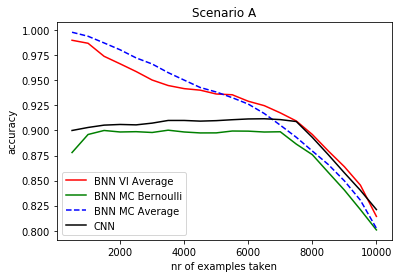

In [13]:
import matplotlib.pyplot as plt

#plt.plot(x, b_vi, label='BNN VI Bernoulli', color='red', linestyle='--')
plt.plot(x, a_vi, label='BNN VI Average', color='red')
plt.plot(x, b_mc, label='BNN MC Bernoulli', color='green', linestyle='-')
plt.plot(x, a_mc, label='BNN MC Average', color='blue', linestyle='--')
plt.plot(x, cnn, label='CNN', color='black')
#plt.plot(x, mc, label='BNN MC', color='orange', linestyle='-')
#plt.plot(x, vi, label='BNN VI', color='blue', linestyle='-')

plt.xlabel('nr of examples taken')
plt.ylabel('accuracy')
#plt.xticks(x)
#plt.yticks(list_of_dev) 

plt.legend(loc='lower left')
plt.title("Scenario A")

# check out performance if we overwrite classes based on uncertainty

In [8]:
results = pd.read_csv("D_003_results.csv", ";")

In [9]:
results['soll'] = test_y

In [15]:
testing['a_vi_overwrite'] = np.where(testing['a_vi_std'] >= 0.3, 9, testing['a_vi'])

In [16]:
x = []
b_vi = []
a_vi = []
b_mc = []
a_mc = []
cnn = []
mc = []
vi = []
a_vi_overwrite = []
for i in range(500,10400,500):
    data = testing[0:i]
    x.append(i)
    b_vi.append((data['soll']==data['b_vi']).sum()/i)
    a_vi.append((data['soll']==data['a_vi']).sum()/i)
    b_mc.append((data['soll']==data['b_mc']).sum()/i)
    a_mc.append((data['soll']==data['a_mc']).sum()/i)
    cnn.append((data['soll']==data['cnn']).sum()/i)
    mc.append((data['soll']==data['mc']).sum()/i)
    vi.append((data['soll']==data['vi']).sum()/i)
    a_vi_overwrite.append((data['soll']==data['a_vi_overwrite']).sum()/i)

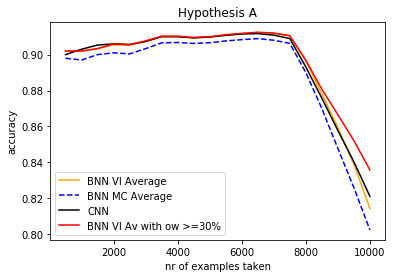

In [17]:
import matplotlib.pyplot as plt

#plt.plot(x, b_vi, label='BNN VI Bernoulli', color='red')
plt.plot(x, a_vi, label='BNN VI Average', color='orange', linestyle= '-')
#plt.plot(x, b_mc, label='BNN MC Bernoulli', color='green', linestyle='-')
plt.plot(x, a_mc, label='BNN MC Average', color='blue', linestyle='--')
plt.plot(x, cnn, label='CNN', color='black')
#plt.plot(x, mc, label='BNN MC', color='blue', linestyle='-')
#plt.plot(x, vi, label='>=50%', color='blue', linestyle='-')
plt.plot(x, a_vi_overwrite, label = 'BNN VI Av with ow >=30%', color = 'red')

plt.xlabel('nr of examples taken')
plt.ylabel('accuracy')
#plt.xticks(x)
#plt.yticks(list_of_dev) 

plt.legend(loc='lower left')
plt.title("Hypothesis A")
plt.show()

## Check a picture with high uncertainty and low uncertainty

Text(0.5, 1.0, 'Hyp A picture with low uncertainty')

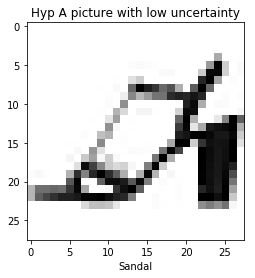

In [12]:
# low uncertainty base on BNN MC Average
testing = results.sort_values(by=['a_mc_std'], ascending = True)
n = testing.index[2]
plt.imshow(np.squeeze(test_x[n:n+1][0], axis = 2), cmap=plt.cm.binary)
plt.xlabel(class_names[test_y[n]])
plt.title('Hyp A picture with low uncertainty')

Text(0.5, 1.0, 'Hyp A picture with high uncertainty')

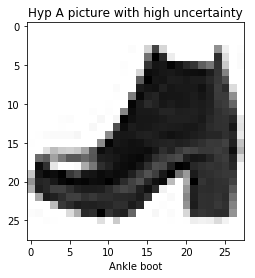

In [13]:
# high uncertainty
n = testing.index[9999]
plt.imshow(np.squeeze(test_x[n:n+1][0], axis = 2), cmap=plt.cm.binary)
plt.xlabel(class_names[test_y[n]])
plt.title('Hyp A picture with high uncertainty')

In [30]:
# determine the number of pictures of the unseen class in the test set
len(np.where(test_y == 9)[0])

1000

# Check what classes with the highest std, are they of the unseen class?

In [18]:
x = []
b_vi = []
a_vi = []
b_mc = []
a_mc = []
cnn = []
mc = []
vi = []
not_seen_class = 1
for i in range(100,10040,100):
    data = results.sort_values(by=['sort_order'], ascending = False)
    data = data[0:i]
    x.append(i)
    b_vi.append((data['soll']==not_seen_class).sum()/i)
    cnn.append((data['soll']==not_seen_class).sum()/i)
    mc.append((data['soll']==not_seen_class).sum()/i)
    vi.append((data['soll']==not_seen_class).sum()/i)
    data = results.sort_values(by=['a_vi_std'], ascending = False)
    data = data[0:i]
    a_vi.append((data['soll']==not_seen_class).sum()/i)
    data = results.sort_values(by=['b_mc_std'], ascending = False)
    data = data[0:i]
    b_mc.append((data['soll']==not_seen_class).sum()/i)
    data = results.sort_values(by=['a_mc_std'], ascending = False)
    data = data[0:i]
    a_mc.append((data['soll']==not_seen_class).sum()/i)
    data = results 

In [72]:
n = len(x)
random_classifier = np.full((n), 0.1)
optimal_classifier = np.full((round(n*0.9)), 0)
optimal_more = []
bound = 90
for i in range(round(n)):
    if i < bound:
        j = 0
    else:
        j = (i-bound)/n
    optimal_more.append(j)
print(optimal_more)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]


Text(0.5, 1.0, 'Scenario A ratio unseen class')

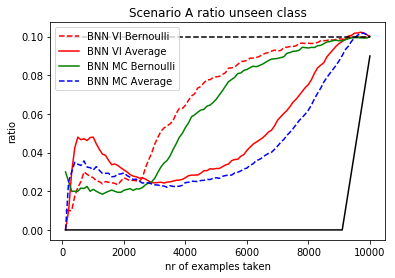

In [74]:
import matplotlib.pyplot as plt

plt.plot(x, b_vi, label='BNN VI Bernoulli', color='red', linestyle='--')
plt.plot(x, a_vi, label='BNN VI Average', color='red')
plt.plot(x, b_mc, label='BNN MC Bernoulli', color='green', linestyle='-')
plt.plot(x, a_mc, label='BNN MC Average', color='blue', linestyle='--')
plt.plot(x, random_classifier, color = 'black', linestyle='--')
plt.plot(x, optimal_more, color = 'black', linestyle='-')
#plt.plot(x, cnn, label='CNN', color='black')
#plt.plot(x, mc, label='BNN MC', color='orange', linestyle='-')
#plt.plot(x, vi, label='BNN VI', color='blue', linestyle='-')

plt.xlabel('nr of examples taken')
plt.ylabel('ratio')
#plt.xticks(x)
#plt.yticks(list_of_dev) 

plt.legend(loc='upper left')
plt.title("Scenario A ratio unseen class")